In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from PIL import Image
from scipy.stats import skew
from matplotlib.transforms import Bbox
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv("SAML-D.csv")

In [3]:
df.shape

(9504852, 12)

DATA CLEANING


In [4]:
df = df.sample(n=200000, random_state=1)

df.shape

(200000, 12)

In [5]:
# check for duplicates
df = df.drop_duplicates(keep = 'first')
df.shape

(200000, 12)

In [6]:
df.tail()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
8606623,15:17:25,2023-07-23,7029921966,3828530251,5632.33,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Plus_Mutual
6346650,11:37:07,2023-05-08,3518726122,9768510209,7214.17,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
8957570,18:28:26,2023-08-04,9456347626,1570347336,1940.43,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
7654334,13:26:45,2023-06-21,5296246312,6172615079,6304.50,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Fan_In
9065824,13:04:39,2023-08-08,6517474457,8029865996,775.45,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out


In [7]:
# Check for null or NaN values
print(df.isna().sum())

Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64


In [8]:
# check for blank strings
print((df == '').sum())

Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64


In [9]:
# Data types
print("\nData types:")
print(df.dtypes)


Data types:
Time                       object
Date                       object
Sender_account              int64
Receiver_account            int64
Amount                    float64
Payment_currency           object
Received_currency          object
Sender_bank_location       object
Receiver_bank_location     object
Payment_type               object
Is_laundering               int64
Laundering_type            object
dtype: object


DATA PREPROCESSING

In [10]:
# number of transactions per payment type
transactions_per_payment_type = df['Payment_type'].value_counts()

# number of laundering transactions per payment type
laundering_transactions_per_payment_type = df[df['Is_laundering'] == 1].groupby('Payment_type').size()

transactions_per_payment_type, laundering_transactions_per_payment_type

(Payment_type
 Cheque             42499
 Credit card        42413
 Debit card         42405
 ACH                42146
 Cross-border       19581
 Cash Withdrawal     6205
 Cash Deposit        4751
 Name: count, dtype: int64,
 Payment_type
 ACH                26
 Cash Deposit       31
 Cash Withdrawal    21
 Cheque             23
 Credit card        26
 Cross-border       49
 Debit card         19
 dtype: int64)

In [11]:
df['Sender_bank_location'].unique()

array(['UK', 'UAE', 'Morocco', 'Japan', 'Germany', 'Italy', 'France',
       'Mexico', 'Pakistan', 'Albania', 'Nigeria', 'Switzerland',
       'Turkey', 'Netherlands', 'USA', 'India', 'Austria', 'Spain'],
      dtype=object)

In [12]:
df.describe()

,Sender_account,Receiver_account,Amount,Is_laundering
count,2.000000e+05,2.000000e+05,200000.000000,200000.000000
mean,5.001152e+09,5.001039e+09,8750.761190,0.000975
std,2.887164e+09,2.882951e+09,21957.159439,0.031210
min,3.209500e+04,1.326600e+04,6.140000,0.000000
25%,2.498540e+09,2.512679e+09,2150.647500,0.000000
50%,4.994117e+09,4.996041e+09,6112.375000,0.000000
75%,7.505735e+09,7.489113e+09,10491.497500,0.000000
max,9.999987e+09,9.999958e+09,984679.650000,1.000000


In [13]:
laundering_stats = df[df['Is_laundering'] == 1]['Amount'].agg(['max', 'mean', 'min'])

normal_stats = df[df['Is_laundering'] == 0]['Amount'].agg(['max', 'mean', 'min'])

print("Laundering Transactions Stats:\n", laundering_stats)
print("\nNormal Transactions Stats:\n", normal_stats)

Laundering Transactions Stats:
 max     759709.070000
mean     17432.592045
min         29.070000
Name: Amount, dtype: float64

Normal Transactions Stats:
 max     984679.650000
mean      8742.288144
min          6.140000
Name: Amount, dtype: float64


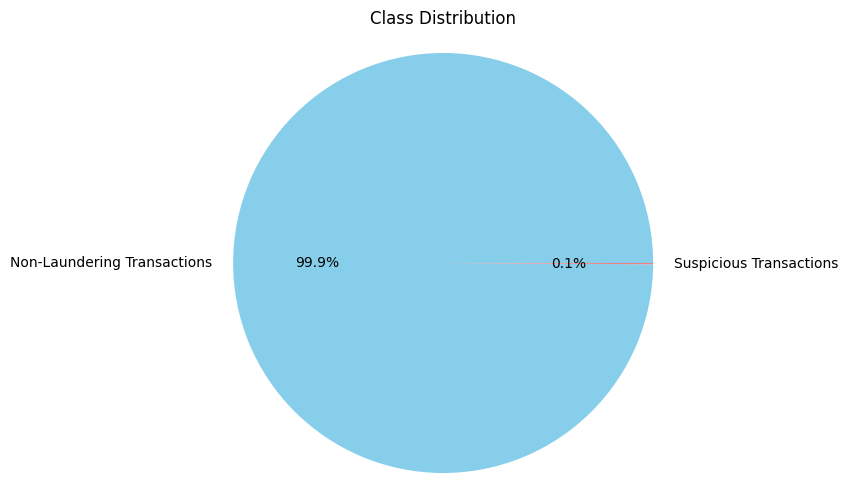

In [14]:
class_distribution = df['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show()

In [15]:
#handling imbalance in the dataset 
#using SMOTE (Synthectic Monitory Over-sampling Technique)
from imblearn.over_sampling import SMOTE

In [16]:
# Check the initial class distribution
print("Initial class distribution:")
print(df['Is_laundering'].value_counts(normalize=True))

Initial class distribution:
Is_laundering
0    0.999025
1    0.000975
Name: proportion, dtype: float64


In [17]:
# Separate the features and the target
X = df.drop(columns=['Is_laundering']) 
y = df['Is_laundering'] #target

In [18]:
# Convert time and date columns to datetime objects
X['Time'] = pd.to_datetime(X['Time'], format='%H:%M:%S')
X['Date'] = pd.to_datetime(X['Date'], format='%Y-%m-%d')

In [19]:
# Extract features from date if needed, here extracting year, month, day
X['Year'] = X['Date'].dt.year
X['Month'] = X['Date'].dt.month
X['Day'] = X['Date'].dt.day

In [20]:
# Extract features from date if needed, here extracting year, month, day
X['Hour'] = X['Time'].dt.hour
X['Minute'] = X['Time'].dt.minute
X['Second'] = X['Time'].dt.second

In [21]:
# Drop the original Date and Time columns
X = X.drop(columns=['Date', 'Time'])

In [22]:
#one hot encoding some columns 
from sklearn.preprocessing import OneHotEncoder

In [23]:
# Identify categorical columns for one-hot encoding
categorical_columns = [
    'Payment_currency', 
    'Received_currency', 
    'Sender_bank_location', 
    'Receiver_bank_location', 
    'Payment_type', 
    'Laundering_type'
]
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=categorical_columns)

In [24]:
# Define the SMOTE model with the desired sampling strategy
#Is_landuring should have around 30% 1's
smote = SMOTE(sampling_strategy=0.3, random_state=42)

In [25]:
# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

In [26]:
data = pd.DataFrame(X_resampled, columns=X.columns)
data['Is_laundering'] = y_resampled

C:\Users\Dell\AppData\Local\Temp\ipykernel_13620\446171337.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Is_laundering'] = y_resampled


In [27]:
# Check the new class distribution
print("New class distribution:")
print(data['Is_laundering'].value_counts(normalize=True))

New class distribution:
Is_laundering
0    0.769232
1    0.230768
Name: proportion, dtype: float64


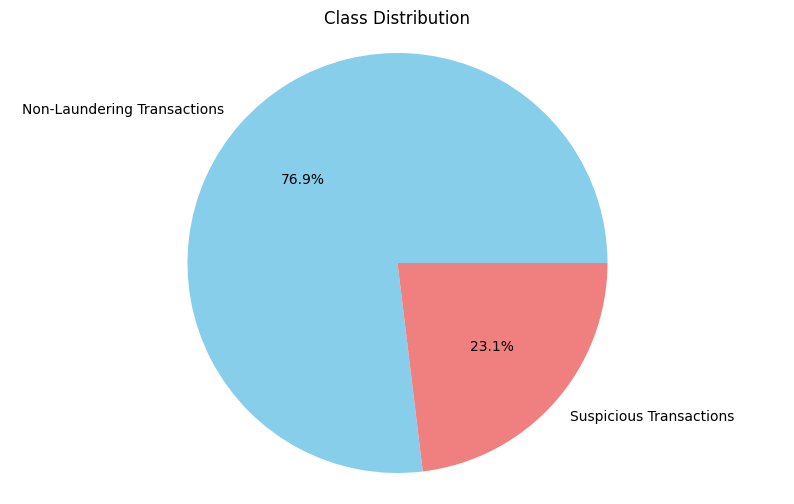

In [28]:
class_distribution = data['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show()

In [29]:
# Data types
print("\nData types:")
print(data.dtypes)


Data types:
Sender_account                         int64
Receiver_account                       int64
Amount                               float64
Year                                   int32
Month                                  int32
                                      ...   
Laundering_type_Single_large            bool
Laundering_type_Smurfing                bool
Laundering_type_Stacked Bipartite       bool
Laundering_type_Structuring             bool
Is_laundering                          int64
Length: 106, dtype: object


In [30]:
data.head()

,Sender_account,Receiver_account,Amount,Year,Month,Day,Hour,Minute,Second,Payment_currency_Albanian lek,...,Laundering_type_Normal_Periodical,Laundering_type_Normal_Plus_Mutual,Laundering_type_Normal_Small_Fan_Out,Laundering_type_Normal_single_large,Laundering_type_Scatter-Gather,Laundering_type_Single_large,Laundering_type_Smurfing,Laundering_type_Stacked Bipartite,Laundering_type_Structuring,Is_laundering
0,4248061080,9527052910,13480.74,2023,8,14,2,8,46,False,...,False,True,False,False,False,False,False,False,False,0
1,9130896737,908371799,10480.05,2023,7,2,19,48,23,False,...,False,False,False,False,False,False,False,False,False,0
2,1466348255,8545558838,26232.35,2023,7,22,12,4,24,False,...,False,False,False,False,False,False,False,False,False,0
3,2181923623,6234034932,447.07,2022,10,28,17,8,2,False,...,False,False,True,False,False,False,False,False,False,0
4,8596132461,3638213339,1005.62,2023,2,21,22,44,17,False,...,False,False,True,False,False,False,False,False,False,0


In [31]:
data.columns[59]

'Receiver_bank_location_Japan'

In [32]:
#creating high_risk_countries column
# List of high-risk countries
high_risk_countries = {"Nigeria", "Morocco", "Turkey", "Pakistan", "Mexico", "Spain"}
# Identify one-hot encoded columns for high-risk countries
sender_columns = [f"Sender_bank_location_{country}" for country in high_risk_countries]
receiver_columns = [f"Receiver_bank_location_{country}" for country in high_risk_countries]

In [33]:
# Check if any of the sender or receiver columns indicate a high-risk country
data['high_risk_countries'] = data[sender_columns + receiver_columns].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

C:\Users\Dell\AppData\Local\Temp\ipykernel_13620\2728784744.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['high_risk_countries'] = data[sender_columns + receiver_columns].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)


In [34]:
data.head()

,Sender_account,Receiver_account,Amount,Year,Month,Day,Hour,Minute,Second,Payment_currency_Albanian lek,...,Laundering_type_Normal_Plus_Mutual,Laundering_type_Normal_Small_Fan_Out,Laundering_type_Normal_single_large,Laundering_type_Scatter-Gather,Laundering_type_Single_large,Laundering_type_Smurfing,Laundering_type_Stacked Bipartite,Laundering_type_Structuring,Is_laundering,high_risk_countries
0,4248061080,9527052910,13480.74,2023,8,14,2,8,46,False,...,True,False,False,False,False,False,False,False,0,0
1,9130896737,908371799,10480.05,2023,7,2,19,48,23,False,...,False,False,False,False,False,False,False,False,0,0
2,1466348255,8545558838,26232.35,2023,7,22,12,4,24,False,...,False,False,False,False,False,False,False,False,0,0
3,2181923623,6234034932,447.07,2022,10,28,17,8,2,False,...,False,True,False,False,False,False,False,False,0,0
4,8596132461,3638213339,1005.62,2023,2,21,22,44,17,False,...,False,True,False,False,False,False,False,False,0,0


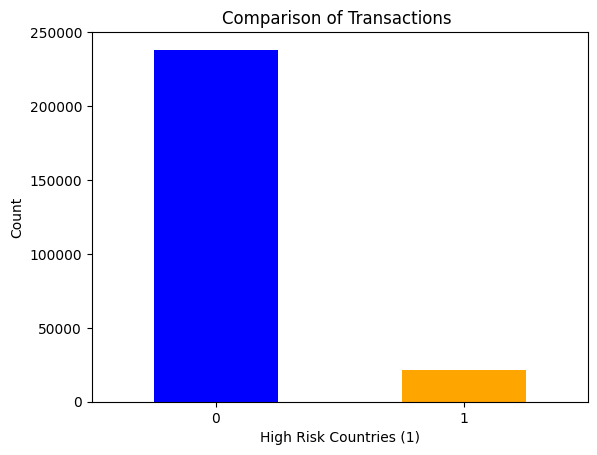

In [35]:
counts = data['high_risk_countries'].value_counts()

# Plotting the counts
counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('High Risk Countries (1)')
plt.ylabel('Count')
plt.title('Comparison of Transactions ')
plt.xticks([0, 1], ['0', '1'], rotation=0)
plt.show()

RNN model

In [36]:
#splitting dataset into features(x) and  target(y) 
X = data[['Day', 'Month', 'Year', 'Hour', 'Minute', 'Second']]
y = data['Is_laundering']

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [40]:
predictions = model.predict(X_test)

In [41]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.988065294389405


Here we construct a confusion matrix to show which of the following has true positive and false negative

In [42]:
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59862
           1       0.97      0.98      0.97     18062

    accuracy                           0.99     77924
   macro avg       0.98      0.99      0.98     77924
weighted avg       0.99      0.99      0.99     77924



In [43]:
#confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(y_test, predictions)

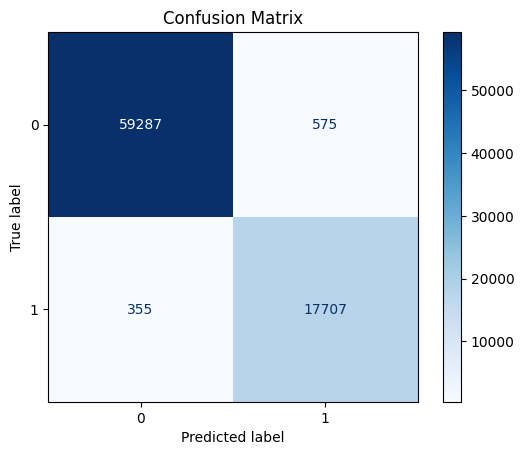

In [44]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

ARIMAX MODEL

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [47]:
model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
arimax_model = model.fit(disp=False)

c:\Users\Dell\OneDrive\Desktop\AML\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dell\OneDrive\Desktop\AML\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dell\OneDrive\Desktop\AML\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
predictions = arimax_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

c:\Users\Dell\OneDrive\Desktop\AML\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Dell\OneDrive\Desktop\AML\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [49]:
predictions_binary = (predictions > 0.5).astype(int)

In [50]:
accuracy = accuracy_score(y_test, predictions_binary)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6587059185873415


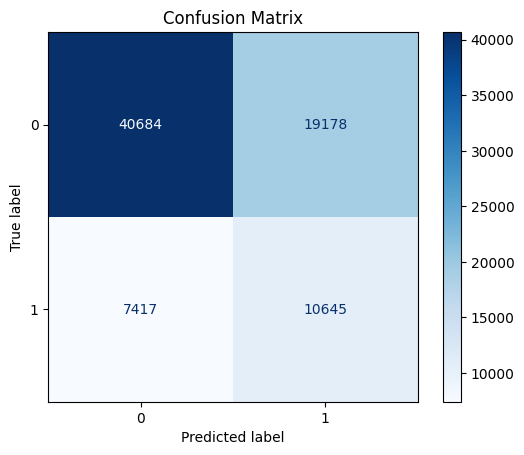

In [51]:
cm = confusion_matrix(y_test, predictions_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Anamolies Detection¶
This is the implementation of machine learning algorithms for the detection of anamolies and outliers and to know the performance for each of the following algorithms.

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer

In [53]:
data.dtypes

Sender_account                         int64
Receiver_account                       int64
Amount                               float64
Year                                   int32
Month                                  int32
                                      ...   
Laundering_type_Smurfing                bool
Laundering_type_Stacked Bipartite       bool
Laundering_type_Structuring             bool
Is_laundering                          int64
high_risk_countries                    int64
Length: 107, dtype: object

In [54]:
import pandas as pd



# Identify boolean columns and convert them to integers
bool_columns = data.select_dtypes(include=['bool', 'object']).columns

for col in bool_columns:
    # Convert boolean-like object columns to actual boolean type first
    if data[col].dtype == 'object':
        data[col] = data[col].map({'True': True, 'False': False, 'true': True, 'false': False})
    
    
    
    # Convert boolean columns to integers
    data[col] = data[col].astype(int)

In [55]:
if data['Is_laundering'].isna().sum() > 0:
    data = data.dropna(subset=['Is_laundering'])

In [56]:
X = data.drop(columns=['Is_laundering'])
y = data['Is_laundering']

In [57]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [58]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

XG BOOST MODEL

In [60]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix , ConfusionMatrixDisplay ,  classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
#This is for fitting the data and training it on the sets
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [62]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [63]:
#This is for finding out how many of the predictions are accurate.
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

Accuracy (Training Set): 1.0000
Accuracy (Testing Set): 1.0000


In [64]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)


Confusion Matrix (Training Set):
 [[159890      0]
 [     0  47906]]


In [65]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)


Confusion Matrix (Testing Set):
 [[39915     0]
 [    2 12033]]


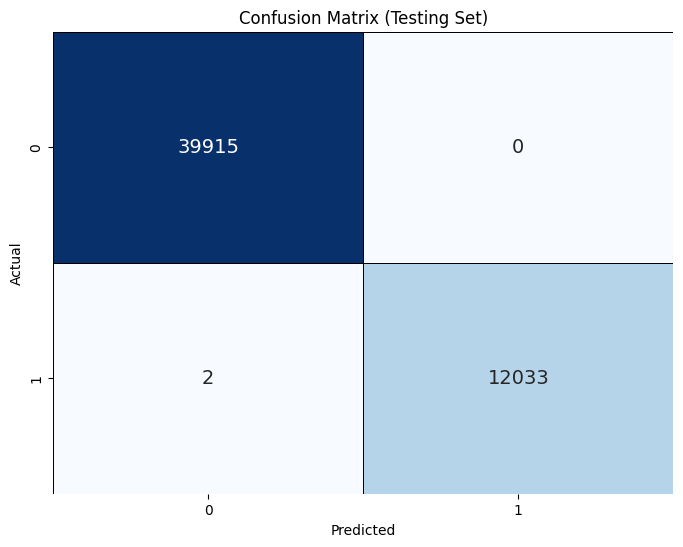

In [66]:
# Plotting confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [67]:
# Classification report for testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))


Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39915
           1       1.00      1.00      1.00     12035

    accuracy                           1.00     51950
   macro avg       1.00      1.00      1.00     51950
weighted avg       1.00      1.00      1.00     51950



Random Forest Model

In [68]:
pip install catboost

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [70]:
#Initialising the model
rf_model = RandomForestClassifier(random_state=42)

In [71]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [72]:
# Predictions on training and testing sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [73]:
#Calculating the accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

Accuracy (Training Set): 1.0000
Accuracy (Testing Set): 0.9999


In [74]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)


Confusion Matrix (Training Set):
 [[159890      0]
 [     0  47906]]


In [75]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)


Confusion Matrix (Testing Set):
 [[39915     0]
 [    3 12032]]


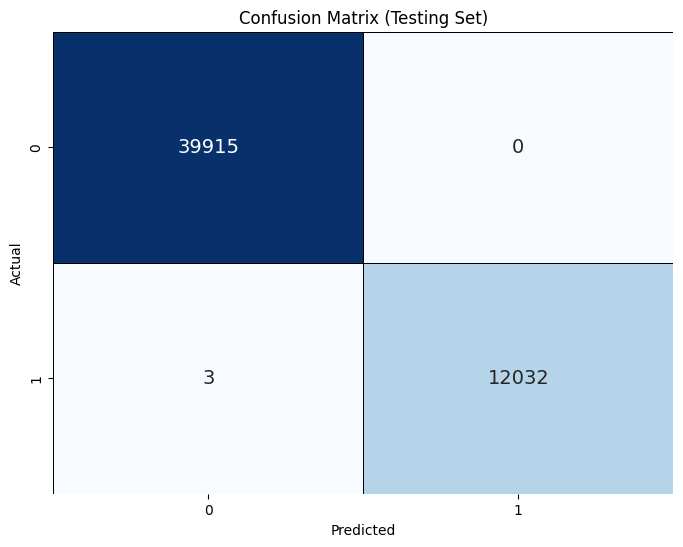

In [76]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [77]:
#Classification report for the testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))


Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39915
           1       1.00      1.00      1.00     12035

    accuracy                           1.00     51950
   macro avg       1.00      1.00      1.00     51950
weighted avg       1.00      1.00      1.00     51950



CATBOOST MODEL


In [78]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [79]:
cat_model = CatBoostClassifier(iterations=1000,  # Number of trees (iterations)
                           learning_rate=0.1,  # Learning rate
                           depth=6,  # Depth of trees
                           random_state=42,  # Random state for reproducibility
                           verbose=0)

In [80]:
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

0:	learn: 0.5063779	test: 0.5059263	best: 0.5059263 (0)	total: 184ms	remaining: 3m 4s
100:	learn: 0.0003898	test: 0.0004764	best: 0.0004764 (100)	total: 3.25s	remaining: 28.9s
200:	learn: 0.0003895	test: 0.0004761	best: 0.0004761 (199)	total: 5.81s	remaining: 23.1s
300:	learn: 0.0003893	test: 0.0004759	best: 0.0004759 (300)	total: 8.54s	remaining: 19.8s
400:	learn: 0.0003891	test: 0.0004757	best: 0.0004757 (399)	total: 11.1s	remaining: 16.6s
500:	learn: 0.0003888	test: 0.0004754	best: 0.0004754 (499)	total: 14.1s	remaining: 14s
600:	learn: 0.0003886	test: 0.0004752	best: 0.0004752 (600)	total: 17.9s	remaining: 11.9s
700:	learn: 0.0003885	test: 0.0004750	best: 0.0004750 (689)	total: 23.1s	remaining: 9.85s
800:	learn: 0.0003883	test: 0.0004748	best: 0.0004748 (799)	total: 27.4s	remaining: 6.81s
900:	learn: 0.0003881	test: 0.0004746	best: 0.0004746 (896)	total: 31.3s	remaining: 3.44s
999:	learn: 0.0003880	test: 0.0004746	best: 0.0004746 (993)	total: 35s	remaining: 0us

bestTest = 0.000474

In [81]:
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

In [82]:
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

Accuracy (Training Set): 1.0000
Accuracy (Testing Set): 0.9999


In [83]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)


Confusion Matrix (Training Set):
 [[159890      0]
 [     4  47902]]


In [84]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)


Confusion Matrix (Testing Set):
 [[39915     0]
 [    5 12030]]


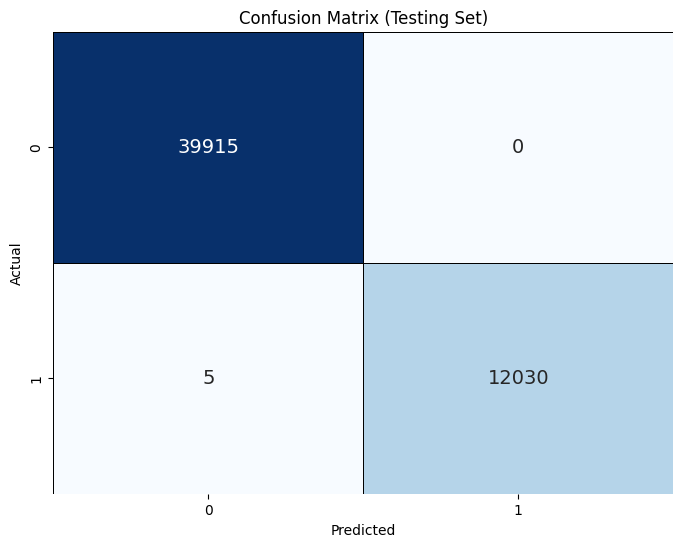

In [85]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [86]:
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))


Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39915
           1       1.00      1.00      1.00     12035

    accuracy                           1.00     51950
   macro avg       1.00      1.00      1.00     51950
weighted avg       1.00      1.00      1.00     51950



ISOLATED FOREST

In [87]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report

In [88]:
isf_model = IsolationForest(random_state=42, contamination='auto')

In [89]:
# Train the model
isf_model.fit(X_train)

IsolationForest(random_state=42)

In [90]:
# Predictions on training and testing sets
y_train_pred = isf_model.predict(X_train)
y_test_pred = isf_model.predict(X_test)

In [91]:
# Convert predictions to binary labels: 1 (normal) and -1 (anomaly)
y_train_pred_binary = [1 if x == 1 else 0 for x in y_train_pred]
y_test_pred_binary = [1 if x == 1 else 0 for x in y_test_pred]

In [92]:
cm_train = confusion_matrix(y_train, y_train_pred_binary)
print("\nConfusion Matrix (Training Set):\n", cm_train)


Confusion Matrix (Training Set):
 [[   134 159756]
 [   940  46966]]


In [93]:
cm_test = confusion_matrix(y_test, y_test_pred_binary)
print("\nConfusion Matrix (Testing Set):\n", cm_test)


Confusion Matrix (Testing Set):
 [[   31 39884]
 [  224 11811]]


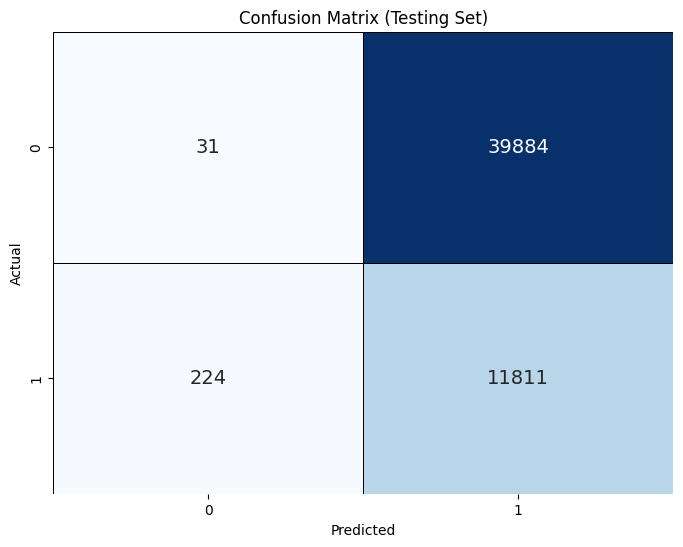

In [94]:
# Plotting confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [95]:
# Classification report for testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred_binary))


Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       0.12      0.00      0.00     39915
           1       0.23      0.98      0.37     12035

    accuracy                           0.23     51950
   macro avg       0.18      0.49      0.19     51950
weighted avg       0.15      0.23      0.09     51950



IMPLEMENTATION OF AUTOENCODER MODEL

The autoencoder model is used to encode all the on hot encoded columns down to 8 columns , this process is done to check the accuracy of anomaly dectecion models accurately

In [96]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

In [97]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [98]:
if np.isnan(X_scaled).any() or np.isinf(X_scaled).any():
    print("Scaled data contains NaN or Infinite values")

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

We derive the functionality to a factor of 8

In [100]:
input_dim = X_train.shape[1]
encoding_dim = 8

In [101]:
input_layer = Input(shape=(input_dim,))

In [102]:
#we have created 3 layers to improve the encoding accuracy
encoder = Dense(64, activation='relu', kernel_initializer='he_normal')(input_layer)
encoder = Dense(32, activation='relu', kernel_initializer='he_normal')(encoder)
encoded = Dense(encoding_dim, activation='relu', kernel_initializer='he_normal')(encoder)
decoder = Dense(32, activation='relu', kernel_initializer='he_normal')(encoded)
decoder = Dense(64, activation='relu', kernel_initializer='he_normal')(decoder)
decoded = Dense(input_dim, activation='sigmoid')(decoder)

In [103]:
autoencoder = Model(inputs=input_layer, outputs=decoded)

In [104]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 106)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 106)            │         6,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,482 (72.20 KB)

 Trainable params: 18,482 (72.20 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
optimizer = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

In [106]:
history=autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1257 - val_loss: 0.0269
Epoch 2/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0247 - val_loss: 0.0199
Epoch 3/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0190 - val_loss: 0.0166
Epoch 4/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0162 - val_loss: 0.0153
Epoch 5/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 6/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0145 - val_loss: 0.0141
Epoch 7/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 8/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 9/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 10/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 11/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 12/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

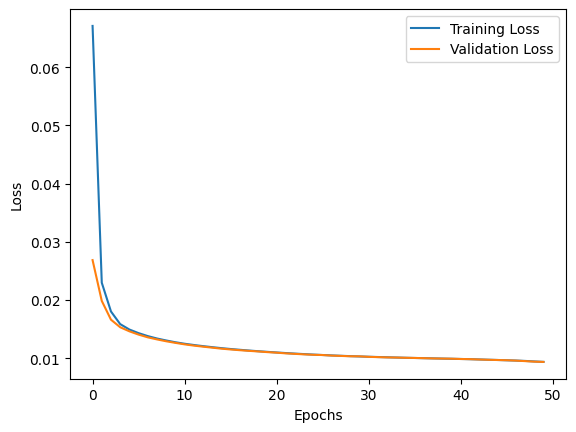

In [107]:
# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
encoder_model = Model(inputs=input_layer, outputs=encoded)

In [109]:
encoded_data = encoder_model.predict(X_scaled)

8118/8118 ━━━━━━━━━━━━━━━━━━━━ 8s 950us/step


In [110]:
if np.isnan(encoded_data).any() or np.isinf(encoded_data).any():
    print("Encoded data contains NaN or Infinite values")

In [111]:
encoded_features_df = pd.DataFrame(encoded_data, columns=[f'Encoded_Feature_{i+1}' for i in range(encoding_dim)])

In [112]:
new_dataset = pd.concat([encoded_features_df, y.reset_index(drop=True)], axis=1)

In [113]:
autoencoder.save('autoencoder_model.h5')
encoder_model.save('encoder_model.h5')

In [114]:
print(new_dataset.head())

   Encoded_Feature_1  Encoded_Feature_2  Encoded_Feature_3  Encoded_Feature_4  \
0           0.026539                0.0          13.328770          10.976533   
1           1.641571                0.0           6.863245          11.642753   
2           2.265923                0.0           6.898091          21.464565   
3           3.276502                0.0           3.407306          13.279181   
4           4.417620                0.0           2.669584          25.362141   

   Encoded_Feature_5  Encoded_Feature_6  Encoded_Feature_7  Encoded_Feature_8  \
0          23.822832          37.062092           7.942963          15.597976   
1          29.566231          37.095749           9.602611           8.997387   
2          24.668116          28.772600          13.333136          18.506638   
3          27.044081          31.687014           5.682303           9.991642   
4          31.704617          34.037819          18.652233          18.757845   

   Is_laundering  
0      

Anomalies detection to the encoded columns

In [115]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer

In [116]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [117]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Note - Our Data is structured in such a way that all the models can learn effectively,hence performing similarly.

XG boost

In [119]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix , ConfusionMatrixDisplay ,  classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
#This is for fitting the data and training it on the sets
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [121]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [122]:
#This is for finding out how many of the predictions are accurate.
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

Accuracy (Training Set): 1.0000
Accuracy (Testing Set): 1.0000


In [123]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)


Confusion Matrix (Training Set):
 [[159890      0]
 [     0  47906]]


In [124]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)


Confusion Matrix (Testing Set):
 [[39915     0]
 [    2 12033]]


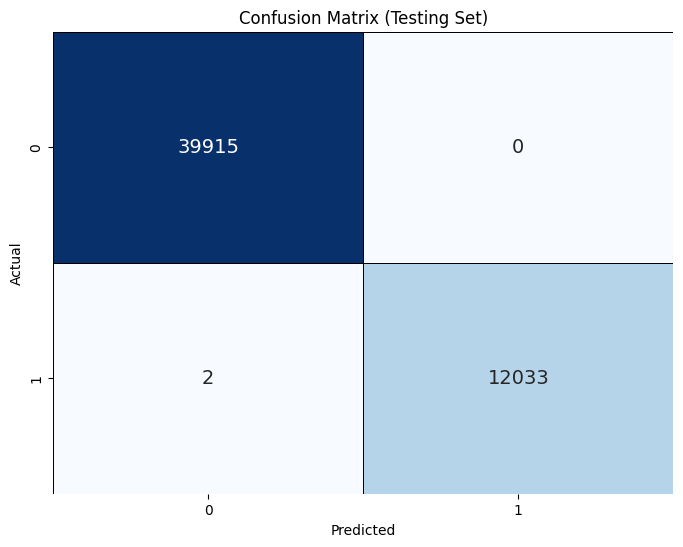

In [125]:
# Plotting confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [126]:
# Classification report for testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))


Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39915
           1       1.00      1.00      1.00     12035

    accuracy                           1.00     51950
   macro avg       1.00      1.00      1.00     51950
weighted avg       1.00      1.00      1.00     51950



Random Forest

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [128]:
#Initialising the model
rf_model = RandomForestClassifier(random_state=42)

In [129]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [130]:
#Predictions on training and testing set
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [131]:
#Calculating the accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

Accuracy (Training Set): 1.0000
Accuracy (Testing Set): 0.9999


In [132]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)


Confusion Matrix (Training Set):
 [[159890      0]
 [     0  47906]]


In [133]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)


Confusion Matrix (Testing Set):
 [[39915     0]
 [    3 12032]]


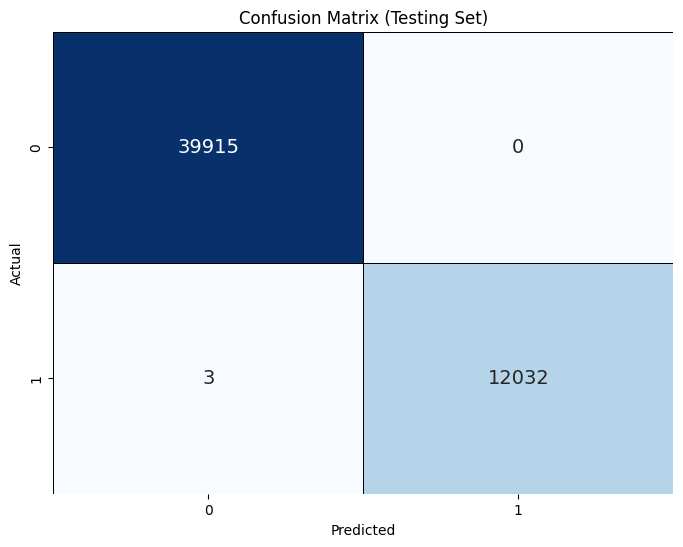

In [134]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [135]:
#Classification report for the testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))


Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39915
           1       1.00      1.00      1.00     12035

    accuracy                           1.00     51950
   macro avg       1.00      1.00      1.00     51950
weighted avg       1.00      1.00      1.00     51950



CATBOOST model

In [136]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [137]:
cat_model = CatBoostClassifier(iterations=1000,  # Number of trees (iterations)
                           learning_rate=0.1,  # Learning rate
                           depth=6,  # Depth of trees
                           random_state=42,  # Random state for reproducibility
                           verbose=0)

In [138]:
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

0:	learn: 0.5063779	test: 0.5059263	best: 0.5059263 (0)	total: 47.7ms	remaining: 47.7s
100:	learn: 0.0003898	test: 0.0004764	best: 0.0004764 (100)	total: 3.71s	remaining: 33s
200:	learn: 0.0003895	test: 0.0004761	best: 0.0004761 (199)	total: 6.46s	remaining: 25.7s
300:	learn: 0.0003893	test: 0.0004759	best: 0.0004759 (300)	total: 9.1s	remaining: 21.1s
400:	learn: 0.0003891	test: 0.0004757	best: 0.0004757 (399)	total: 11.7s	remaining: 17.4s
500:	learn: 0.0003888	test: 0.0004754	best: 0.0004754 (499)	total: 14.2s	remaining: 14.2s
600:	learn: 0.0003886	test: 0.0004752	best: 0.0004752 (600)	total: 17.6s	remaining: 11.7s
700:	learn: 0.0003885	test: 0.0004750	best: 0.0004750 (689)	total: 21.5s	remaining: 9.16s
800:	learn: 0.0003883	test: 0.0004748	best: 0.0004748 (799)	total: 25.1s	remaining: 6.24s
900:	learn: 0.0003881	test: 0.0004746	best: 0.0004746 (896)	total: 29.1s	remaining: 3.19s
999:	learn: 0.0003880	test: 0.0004746	best: 0.0004746 (993)	total: 33s	remaining: 0us

bestTest = 0.000474

In [140]:
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

In [141]:
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

Accuracy (Training Set): 1.0000
Accuracy (Testing Set): 0.9999


In [142]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)


Confusion Matrix (Training Set):
 [[159890      0]
 [     4  47902]]


In [143]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)


Confusion Matrix (Testing Set):
 [[39915     0]
 [    5 12030]]


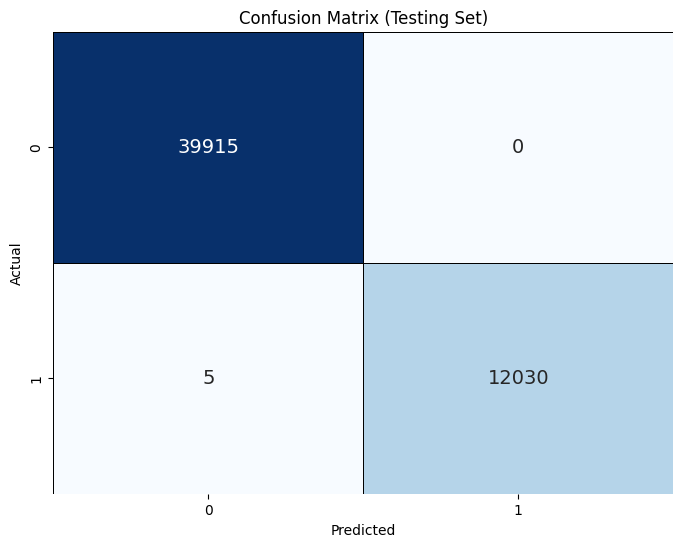

In [144]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [145]:
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))


Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39915
           1       1.00      1.00      1.00     12035

    accuracy                           1.00     51950
   macro avg       1.00      1.00      1.00     51950
weighted avg       1.00      1.00      1.00     51950



In [147]:
import joblib

In [148]:
joblib.dump(model, 'model.pkl')

['model.pkl']